# 1. Setting Up Environment and loading necessary libraries

In [67]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import json
import re
import ssl
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    LSTM,
    GRU,
    Dense,
    Dropout,
    Bidirectional,
)
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 2. Dataset Selection

In [66]:
# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/MCSC/TME_6015/Project/Model_2__Emotion_Combined.csv')

print(f'The dataset for training has a shape of {df.shape}')

Mounted at /content/drive
The dataset for training has a shape of (31476, 2)


# 3. Data Preprocessing

In [68]:
# Load the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to clean and preprocess text
def clean_text(text):
    whitelist = ['not']
    # Remove non-English characters
    text = ''.join([c for c in text if ord(c) < 128])
    # Remove numbers and special symbols, and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words or word.lower() in whitelist])
    return text

label_mapping = {
    "love": "pleased",
    "surprise": "happy",
    "fear": "frustrated",
    "anger": "frustrated",
    "angry": "frustrated",
    "sadness":"sad",
    "disgust":"sad",

}

# Create a new column 'Updated_Label' with the updated labels based on the mapping
def update_label(label):
    if label in label_mapping:
        return label_mapping[label]
    else:
        return label


texts = df['Review'].apply(clean_text)

labels = df['Updated_Label'] = df['Label'].apply(update_label)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
encoded_labels = label_encoder.fit_transform(labels)

# To see the mapping of string labels to integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping: ", label_mapping)

# Hyperparameters
vocab_size = 10000  # Number of unique words in the vocabulary
embedding_dim = 100  # Number of dimensions for each word vector
max_length = 100    # Max length of each input sequence
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"   # Token for out-of-vocabulary words

# Tokenize the text
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(padded, encoded_labels, test_size=0.2, random_state=42)

Label Mapping:  {'frustrated': 0, 'happy': 1, 'pleased': 2, 'sad': 3}


# 4. Model Selection - Build and Compile

In [69]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(32)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Using Adam optimizer with a different learning rate
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 5. Training/Fine-Tuning

In [70]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(train_texts, train_labels, epochs=20, batch_size=64, validation_data=(val_texts, val_labels), callbacks=[early_stopping])

Epoch 1/20
394/394 [==============================] - 26s 50ms/step - loss: 1.4163 - accuracy: 0.5087 - val_loss: 0.8145 - val_accuracy: 0.7519
Epoch 2/20
394/394 [==============================] - 8s 21ms/step - loss: 0.5848 - accuracy: 0.8407 - val_loss: 0.4400 - val_accuracy: 0.8698
Epoch 3/20
394/394 [==============================] - 8s 21ms/step - loss: 0.3087 - accuracy: 0.9238 - val_loss: 0.3643 - val_accuracy: 0.8931
Epoch 4/20
394/394 [==============================] - 8s 21ms/step - loss: 0.2111 - accuracy: 0.9502 - val_loss: 0.3709 - val_accuracy: 0.8879
Epoch 5/20
394/394 [==============================] - 7s 18ms/step - loss: 0.1603 - accuracy: 0.9638 - val_loss: 0.3751 - val_accuracy: 0.8928
Epoch 6/20
394/394 [==============================] - 7s 18ms/step - loss: 0.1334 - accuracy: 0.9688 - val_loss: 0.3953 - val_accuracy: 0.8933
Epoch 7/20
394/394 [==============================] - 7s 18ms/step - loss: 0.1169 - accuracy: 0.9752 - val_loss: 0.4099 - val_accuracy: 0.894

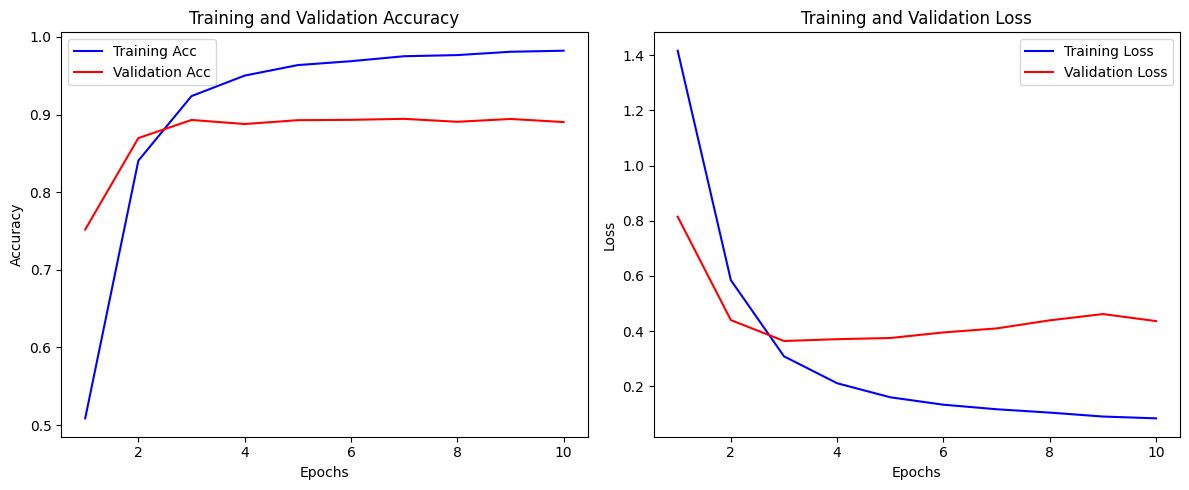

In [71]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Extracting the data from the history dictionary
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plotting training and validation accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Acc')
    plt.plot(epochs, val_acc, 'r', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history.history)

# 6. Hyperparamter Tuning & Evaluation Metrics

// TODO Section - ASHWANT

1.   Experimenting with epoch
2.   Experimenting with learning rate

Print all the success metrics for all experiements, and print the same for our finalized model/params at the end.

Based on the experimentation, we arrived at the final model and parameters with which we've now trained the model.



# 7. Running Predictions on Test Data

In [72]:
# Testing the model with an example feedback
def predict_sentiment(text):
    # Tokenize and pad the text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    # Predict
    prediction = model.predict(padded_sequence)
    sentiment = label_encoder.inverse_transform([np.argmax(prediction)])[0]

    return sentiment

# Example usage
feedback = "Unsatisfied with the outdated course."  # Replace with your sentence
predicted_sentiment = predict_sentiment(feedback)
print(f"The predicted sentiment is: {predicted_sentiment}")

1/1 [==============================] - 1s 998ms/step
The predicted sentiment is: frustrated


In [73]:
# run the predictions on a test dataset and generate the output file - emotions.json
def remove_stop_words_from_list(texts):
    # Define a list of words to whitelist
    whitelist = []
    processed_texts = []
    for text in texts:
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        processed_text = ' '.join([word for word in text.split() if word.lower() not in stop_words or word.lower() in whitelist])
        processed_texts.append(processed_text)
    return processed_texts

def read_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

df = pd.read_csv('/content/drive/MyDrive/MCSC/TME_6015/Project/test_data_set_all_model.csv')

test_messages = df['Feedback'].to_list()

predicted_sentiments = {str(i+1): predict_sentiment(message) for i, message in enumerate(test_messages)}

# printing the first 5 sentiment outputs
index = 1
for message in enumerate(test_messages):
    if( i>5):
      break
    predicted_feeling = predicted_sentiments[str(index)]
    print(f"Message {index}: {message}")
    print(f"Predicted Feeling: {predicted_feeling}\n")
    index += 1

# Write the dictionary to a JSON file
with open('/content/drive/MyDrive/MCSC/TME_6015/Project/emotions.json', 'w') as json_file:
    json.dump(predicted_sentiments, json_file, indent=4)

print("Sentiments written to emotions.json")

1/1 [==============================] - 0s 22ms/step
Sentiments written to emotions.json
